In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
# import seaborn as sns
import statsmodels.api as sm
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LearningCurveDisplay
from sklearn.compose import ColumnTransformer
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')
random.seed(123)

In [ ]:
df = pd.read_csv("../dataset/train.csv")
print(df)


        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [4]:
print(df.shape)
print(df.dtypes)

(1460, 81)
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


***Número de filas:*** 1460

***Número de atributos o columnas:*** 81

Conjuntos de entrenamiento y prueba

In [5]:
y = df.pop("SalePrice")
X = df

In [6]:
X_train, X_test,y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train.isnull().sum())
print(X_test.isnull().sum())



(1168, 80)
(292, 80)
(1168,)
(292,)
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      224
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 80, dtype: int64
Id                0
MSSubClass        0
MSZoning          0
LotFrontage      35
LotArea           0
                 ..
MiscVal           0
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
Length: 80, dtype: int64


## MODELOS

Arbol de regresion
Hacemos un modelo lineal multiple usando todos los predictores. Separamos la variable numericas de las categoricas, las categoricas nos aportan mas informacion, son las que nos interesa evaluar.

In [7]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)
categorical_columns

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Para las categoricas se les hace un OneHotEncoder, en este encoder para cada categoria se crea una variable dicotomica

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definir columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocesador con imputación y escalado
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),  # Imputar valores NaN en numéricas con la media
        ('scaler', StandardScaler())  # Escalar valores numéricos
    ]), numerical_columns),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),  # Imputar valores NaN en categóricas con la moda
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación One-Hot
    ]), categorical_columns)
])


In [9]:
print(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'Bsm...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])


Se hace una tuberia donde se codifican las variables categoricas y se crea el modelo de arbol de regresion. Luego se tunea el parametro de max_depth y se imprime el mejor parametro

In [10]:
param_grid = {"max_depth": np.arange(5, 10, 1)} # sobre qué numero de max-depth vamos a iterar
pipeline = Pipeline(
    [('preprocessor',preprocessor),
     ('regressor',DecisionTreeRegressor())]) # probamos múltiples modelos con el preprocessor previo
params = [{
    "regressor__max_depth": np.arange(5, 10, 1)
}]
modelo1 = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error") # evaluamos usando CV para ver cuál es el mejor modelo de todos 
modelo1.fit(X_train,y_train)
modelo1.best_params_

{'regressor__max_depth': np.int64(8)}

Se predice con el mejor modelo

In [11]:
modelo1_pred = modelo1.predict(X_test)
modelo1_pred


array([146609.8       , 165916.66666667, 217195.78947368, 181930.76923077,
       146609.8       , 160562.69387755, 239442.66666667, 389716.        ,
       178136.01785714, 178136.01785714, 134481.16666667, 154344.        ,
       158260.        , 116425.07377049, 155800.        ,  84500.        ,
       206166.66666667, 193580.        , 196390.48192771, 405632.33333333,
       178136.01785714, 146609.8       , 203544.44444444, 239833.33333333,
        93422.92105263, 137100.        , 131432.35294118, 196390.48192771,
       253362.92857143, 116425.07377049, 146609.8       , 160562.69387755,
       137917.96969697, 210445.5       , 178136.01785714, 179714.28571429,
        78605.375     , 178136.01785714, 220000.        , 173733.        ,
       255993.33333333, 130035.48387097, 130336.53846154, 178136.01785714,
       135000.        , 242562.        , 178136.01785714, 322807.38461538,
       143500.        , 227001.76470588, 130035.48387097, 196390.48192771,
       160562.69387755, 2

### Metricas de Evaluacion

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
mae = mean_absolute_error(y_test, modelo1_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, modelo1_pred)
print(f"MSE: {mse:.4f}")

MAE: 24226.3761
MSE: 1324325912.3989


Errores

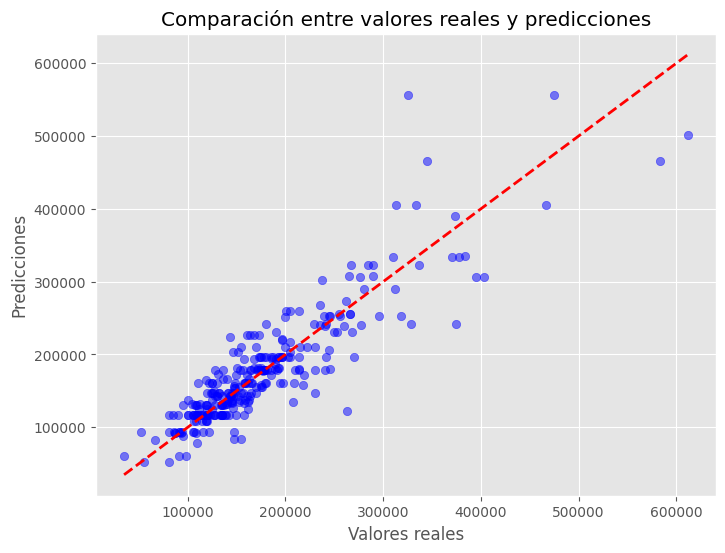

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, modelo1_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea diagonal
plt.title("Comparación entre valores reales y predicciones")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.show()

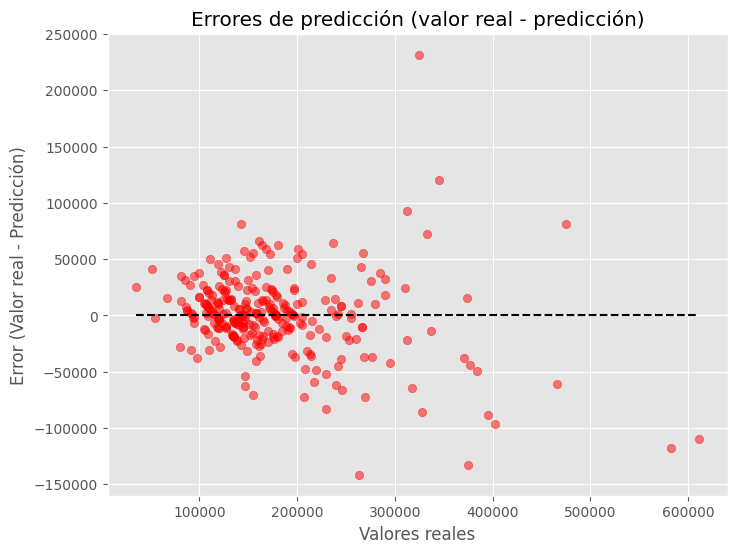

In [15]:
errores = modelo1_pred - y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, errores, color='red', alpha=0.5)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='black', linestyles='dashed')
plt.title("Errores de predicción (valor real - predicción)")
plt.xlabel("Valores reales")
plt.ylabel("Error (Valor real - Predicción)")
plt.show()

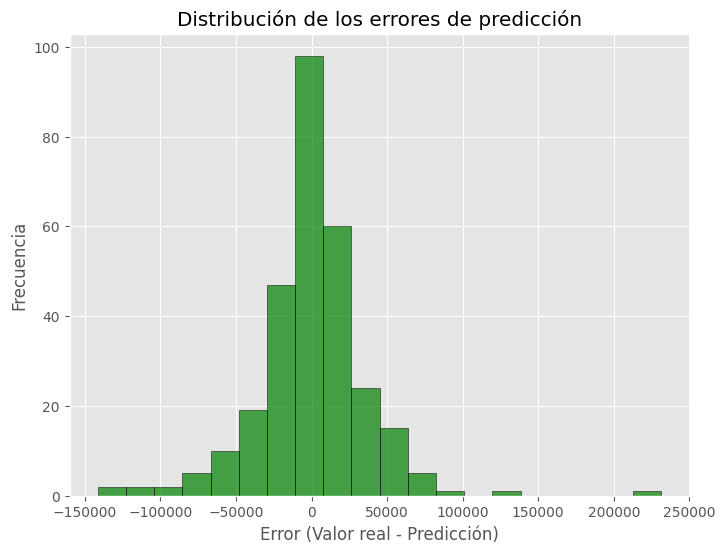

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(errores, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title("Distribución de los errores de predicción")
plt.xlabel("Error (Valor real - Predicción)")
plt.ylabel("Frecuencia")
plt.show()

In [17]:
param_grid = {"max_depth": np.arange(3, 50, 2)} # sobre qué numero de max-depth vamos a iterar
pipeline = Pipeline(
    [('preprocessor',preprocessor),
     ('regressor',DecisionTreeRegressor())]) # probamos múltiples modelos con el preprocessor previo
params = [{
    "regressor__max_depth": np.arange(3, 50, 2)
}]
modelo1 = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error") # evaluamos usando CV para ver cuál es el mejor modelo de todos 
modelo1.fit(X_train,y_train)
modelo1.best_params_

{'regressor__max_depth': np.int64(7)}

In [18]:
modelo1_pred = modelo1.predict(X_test)
modelo1_pred

array([145668.74242424, 154000.        , 220229.45454545, 177955.17241379,
       145668.74242424, 162717.09803922, 220229.45454545, 381056.5       ,
       174772.40983607, 174772.40983607, 141973.375     , 161903.46666667,
       175460.        , 117717.73015873, 147237.5       , 145668.74242424,
       254000.        , 210536.36363636, 198667.8021978 , 393729.33333333,
       174772.40983607, 145668.74242424, 218261.53846154, 249800.        ,
        97534.91111111, 174772.40983607, 136213.15789474, 198667.8021978 ,
       238906.80645161, 117717.73015873, 145668.74242424, 162717.09803922,
       130413.32692308, 223259.        , 174772.40983607, 254000.        ,
        70089.53333333, 174772.40983607, 224728.        , 140051.72413793,
       263619.44444444, 132257.14285714, 119755.        , 174772.40983607,
       134450.        , 244421.5       , 174772.40983607, 310794.3125    ,
       137037.5       , 238906.80645161, 132257.14285714, 198667.8021978 ,
       162717.09803922, 2

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
mae = mean_absolute_error(y_test, modelo1_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, modelo1_pred)
print(f"MSE: {mse:.4f}")

MAE: 23306.3069
MSE: 1156119900.5642


In [21]:
param_grid = {"max_depth": np.arange(5, 40, 8)} # sobre qué numero de max-depth vamos a iterar
pipeline = Pipeline(
    [('preprocessor',preprocessor),
     ('regressor',DecisionTreeRegressor())]) # probamos múltiples modelos con el preprocessor previo
params = [{
    "regressor__max_depth": np.arange(5, 40, 8)
}]
modelo1 = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error") # evaluamos usando CV para ver cuál es el mejor modelo de todos 
modelo1.fit(X_train,y_train)
modelo1.best_params_

modelo1_pred = modelo1.predict(X_test)
modelo1_pred

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, modelo1_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, modelo1_pred)
print(f"MSE: {mse:.4f}")

MAE: 24718.4646
MSE: 1424413823.0674


In [23]:
param_grid = {"max_depth": np.arange(8, 100, 7)} # sobre qué numero de max-depth vamos a iterar
pipeline = Pipeline(
    [('preprocessor',preprocessor),
     ('regressor',DecisionTreeRegressor())]) # probamos múltiples modelos con el preprocessor previo
params = [{
    "regressor__max_depth": np.arange(8, 100, 7)
}]
modelo1 = GridSearchCV(pipeline, param_grid=params, n_jobs=2, cv=5,scoring="neg_root_mean_squared_error") # evaluamos usando CV para ver cuál es el mejor modelo de todos 
modelo1.fit(X_train,y_train)
modelo1.best_params_

modelo1_pred = modelo1.predict(X_test)
modelo1_pred

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, modelo1_pred)
print(f"MAE: {mae:.4f}")

mse = mean_squared_error(y_test, modelo1_pred)
print(f"MSE: {mse:.4f}")

MAE: 22834.0970
MSE: 1162919922.1902
